# SQL and Pandas DataFrames

Datalab allows you to use SQL to interact with BigQuery. However, SQL is just the starting point. What Datalab enables you to do is combine the power of declarative SQL, and imperative code (Python) to perform interesting data analysis, visualization and transformation tasks.

As a result, you can use a number of Python data analysis, data wrangling and visualization libraries, such as `numpy`, `pandas`, `matplotlib` and many others. A number of these libraries build on top of a `DataFrame` object.

This notebook shows how you can easily integrate these capabilites together in a single notebook. This functionality is provided by the BigQuery APIs, so the first step is of course to import the module, along with Pandas.

In [1]:
import gcp.bigquery as bq
import pandas as pd

# From SQL to DataFrames

This is quite straightforward. Define some SQL, execute it and get a reference to the results in the form of a `DataFrame`.

In [2]:
%%sql --module requests
SELECT timestamp, latency, endpoint
FROM [cloud-datalab-samples:httplogs.logs_20140615]
WHERE endpoint = 'Popular' OR endpoint = 'Recent'

In [3]:
%%bigquery sample --count 5 --query requests

(rows: 5, time: 1.0s, 15MB processed, job: job_RSqz_wn8il7e-kSy2NjW4F9ADyo)

# Working with DataFrames

The code below constructs a BigQuery `Query` instance, executes the query, and converts the results into a `DataFrame`.

In [4]:
df = bq.Query(requests).to_dataframe()
len(df)

8392

## Data Manipulation

The resulting `DataFrame` can be further transformed, sliced, projected, and inspected using the extensive set of APIs available on the class. Lets print out the first 5 rows.

In [5]:
df.head(5)

,timestamp,latency,endpoint
0,2014-06-15 07:00:01.514197,22,Popular
1,2014-06-15 07:00:01.700211,21,Popular
2,2014-06-15 07:00:01.973441,21,Popular
3,2014-06-15 07:00:02.043231,21,Popular
4,2014-06-15 07:00:02.288373,21,Popular


Or it can be inspected for schema.

In [6]:
df.dtypes

timestamp    datetime64[ns]
latency               int64
endpoint             object
dtype: object

Or further transformed locally, for example to perform grouping.

In [7]:
groups = df.groupby('endpoint')
groups.dtypes

,latency,timestamp
endpoint,,
Popular,int64,datetime64[ns]
Recent,int64,datetime64[ns]


In [8]:
for name, df_group in groups:
  print '%s - %d items' % (name, len(df_group))
  print df_group.head(3)
  print

Popular - 7658 items
                   timestamp  latency endpoint
0 2014-06-15 07:00:01.514197       22  Popular
1 2014-06-15 07:00:01.700211       21  Popular
2 2014-06-15 07:00:01.973441       21  Popular

Recent - 734 items
                    timestamp  latency endpoint
15 2014-06-15 07:02:21.453438      427   Recent
21 2014-06-15 07:03:48.191783      331   Recent
25 2014-06-15 07:04:57.352634      317   Recent



And then analyze a dimension per group.

In [9]:
groups['latency'].describe()

endpoint       
Popular   count     7658.000000
          mean       274.439018
          std        187.050788
          min          2.000000
          25%        132.000000
          50%        313.000000
          75%        392.000000
          max       6443.000000
Recent    count      734.000000
          mean       246.268392
          std        690.888990
          min          2.000000
          25%        184.250000
          50%        229.000000
          75%        288.000000
          max      18715.000000
dtype: float64

Or even run a set of custom aggregation functions.

In [10]:
def unique(x):
  return sorted(set(list(x)))

groups['latency'].agg({ 'list': lambda x: list(x), 'unique': lambda x: unique(x) })

,unique,list
endpoint,,
Popular,"[2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 19, 20, 21, 2...","[22, 21, 21, 21, 21, 316, 402, 405, 126, 351, ..."
Recent,"[2, 3, 4, 5, 6, 10, 21, 22, 23, 24, 29, 31, 35...","[427, 331, 317, 329, 75, 231, 197, 293, 187, 2..."


## Data Visualization

DataFrame provides built-in visualization capabilities using `matplotlib`.

**Conversion to TimeSeries Data**

Right now, the DataFrame instance we have contains timestamps, latencies, and endpoints. Lets reshape this DataFrame so each endpoint is a column instead, i.e. is an independent series. The timestamp itself will be the index row. For timestamps for which one of the endpoints has no data point, we'll just use the previous value.

In [11]:
df_series = df.pivot(index='timestamp', columns='endpoint', values='latency').fillna(method = 'backfill')
df_series[10:20]

endpoint,Popular,Recent
timestamp,,
2014-06-15 07:00:20.649279,177,427
2014-06-15 07:00:54.666471,352,427
2014-06-15 07:01:28.139716,471,427
2014-06-15 07:01:33.672656,394,427
2014-06-15 07:01:37.050927,321,427
2014-06-15 07:02:21.453438,390,427
2014-06-15 07:02:31.533299,390,331
2014-06-15 07:02:51.365249,130,331
2014-06-15 07:02:57.402798,121,331


In [12]:
len(df_series)

8392

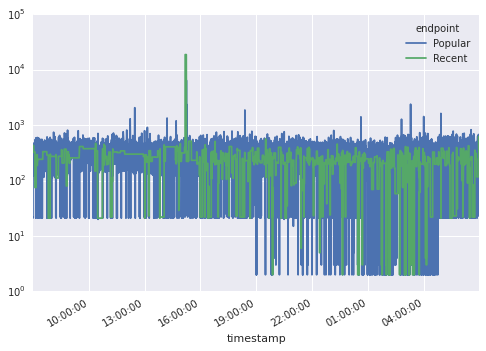

In [13]:
df_series.plot(logy = True)

**Resampling**

The plot above is fairly useless. The time-series data we have is at arbitrary timestamps. Essentially whenever a request was processed. It is irregularly spaced, and fairly large number of data points. DataFrames provide the ability to resample a time-series into more useful time windows.

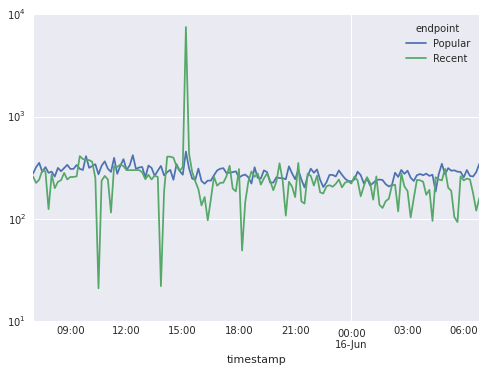

In [14]:
df_series.resample(rule = '10min').plot(logy = True)

# Looking Ahead

Python Pandas provides an extensive toolbox of capabilities for working with data. Datalab combines the power of BigQuery and DataFrames.

Subsequent notebooks will cover additional SQL capabilities, allowing you to use the full power of BigQuery and running queries close to your entire data, before bringing a useful subset of it into the notebook.